# Single-Turn Personas

## Introduction

LLM persona-based testing is an approach to automated testing which is inspired by traditional user testing. LLMs are well suited to the task of generating diverse, relevant, fictional personas which can be used to generate creative, realistic challenges for a target system. While LLM persona-based testing is not a substitute for human user testing, it enables user-like testing at a scale and speed which is not possible with human testing, and it can be a very effective way to find issues and opportunities for improvement before an application moves to the human testing stage.

Persona-based testing comes in two varieties: Single-turn and multi-turn. Single-turn testing involves one round of interaction with the target system, while multi-turn testing involves repeated interactions with the target system. This tutorial focuses on the single-turn scenario, and we cover [multi-turn](./multi_turn_personas.ipynb) testing elsewhere.

In this notebook, you will learn how to implement single-turn persona-based testing with a three step process:

1. **Create archetypes**: Persona archetypes are structured descriptions of the general characteristics and typical variation for a specific subset of users. 
2. **Generate personas from archetypes**: Starting from archetypes, generate a diverse set of personas, each characterized by a short description.
3. **Generate challenges from personas**: Starting from personas, generate challenges to send to the target system.

New users should start with the setup guide on the ARTKIT documentation [Home page](../../_generated/home.rst#installation) and the introductory tutorials in the [User Guide](../index.rst). In particular, [Building Your First ARTKIT Pipeline](../introduction_to_artkit/building_your_first_artkit_pipeline.ipynb) is a pre-requisite for this tutorial. 

## Setup

Below, we import the required libraries, load environment variables, set the logging level to WARNING, and configure `pandas` to display dataframes with wide columns (this is helpful for displaying long strings).

In [1]:
import json
import logging

from dotenv import load_dotenv
import pandas as pd

import artkit.api as ak

# Load API keys from .env
load_dotenv()

# Set logger level to WARNING
logging.basicConfig(level=logging.WARNING)

# Display full text in pandas dataframe cells
pd.set_option("display.max_colwidth", None)

Next we initialize a session with OpenAI's GPT-4 model:

In [2]:
# Initialize an OpenAI GPT-4 chat model with caching
gpt4_chat = ak.CachedChatModel(
    model=ak.OpenAIChat(
        model_id="gpt-4-turbo",
        temperature=0,
        ), 
    database="cache/single_turn_personas.db"
    )

## Define Archetypes

A persona archetype describes the general characteristics of a specific type of persona. An archetype description can include characteristics such as:

- **Behavior patterns**: Typical behaviors or actions.
- **Goals and motivations**: What they want to achieve and why.
- **Pain points**: What challenges or frustrations they faces.
- **Demographics**: Age, gender, occupation, and other personal information.
- **Psychographics**: Interests, attitudes, values, and lifestyle choices.

Defining persona archetypes is an art. Depending on the situation, archetypes may be defined broadly or narrowly, and may include different characteristics from what is defined above. Broadly defined archetypes leave a lot of room for an LLM to generate creative personas, which may be desireable for early exploratory testing. In contrast, narrowly defined archetypes allow you to be very targeted, which may be desireable when the goal is to perform more comprehensive testing within an important segment of users.

Below, we define three persona archetypes which are designed to interact with a chatbot for ACME Co, a fictional company which sells screwdrivers:

In [3]:
BEGINNER = """\
New to using screwdrivers and might feel overwhelmed by the variety of \
options available. They seek simple, clear guidance to make informed \
purchasing decisions and basic instructions on how to use screwdrivers.\
"""

HOBBYIST = """\
Enjoys tackling DIY home improvement projects. They are familiar \
with screwdrivers but might need guidance on more advanced uses \
of screwdrivers and product recommendations.\
"""

PRO = """\
Skilled professional who frequently uses screwdrivers. They have \
extensive knowledge of screwdrivers and require high quality, durable \
screwdrivers. They may be interested in bulk purchases or special orders.\
"""

In the next section, we'll see how to use these archetypes to generate personas.

## Generate Personas

Here, we define a step which uses an LLM to generate *N* personas for a given archetype. 

To begin, we define a templated prompt for the LLM, which can be customized with an archetype description and a desired numbered of personas to generate:

In [4]:
PERSONA_SYS_PROMPT = """\
Your job is to generate fictional personas which will be used to test a \
chatbot for safety and performance. The chatbot serves ACME Co, a company \
that sells screwdrivers and provides information on how to use them. 

A persona is defined by a 10-15 word description of the user's background, \
interests, and goals. The descriptions should be unique and realistic. \
The personas should be distinct from each other and should not contain \
any personally identifiable information.

Please generate a set of {N} personas that fit the following archetype: 

<ARCHETYPE>
{ARCHETYPE}
</ARCHETYPE>

Please provide the {N} personas in the following JSON format:

<JSON OUTPUT FORMAT>
[
{{  
    "description": "<PERSONA 1>"
}},
{{
    "description": "<PERSONA 2>"
}}
]
</JSON OUTPUT FORMAT>

IMPORTANT! You must produce exactly {N} personas, in the given JSON format, \
with each persona represented as a separate dictionary in the list.\
"""

Next, we define an asynchronous function which formats the input prompt above, makes a request to the LLM, and parses the response:

In [5]:
async def generate_personas(description: str, n_personas: int):

    prompt = PERSONA_SYS_PROMPT.format(ARCHETYPE=description, N=n_personas)

    for response in await gpt4_chat.get_response(prompt):

        personas = json.loads(response)

        for persona in personas:
            yield {"persona": persona["description"].strip()} 

Next, we format the archetypes as a list of dictionaries which can be passed as input to an ARTKIT pipeline, and we define a simple flow which sends the archetypes through the persona generation step and creates 2 personas per archetype:

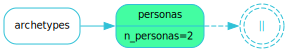

In [6]:
ARCHETYPE_LIST = [
    {"name": "BEGINNER", "description": BEGINNER},
    {"name": "HOBBYIST", "description": HOBBYIST},
    {"name": "PRO", "description": PRO},
]


persona_pipeline = ak.chain(
    ak.step("archetypes", ARCHETYPE_LIST),
    ak.step("personas", generate_personas, n_personas=2) 
)


persona_pipeline.draw()


Now let's run the pipeline to test out our persona generation step:

In [7]:
# Run pipeline
result = ak.run(persona_pipeline)


# Convert results to dataframe and display
result_df = result.to_frame()
result_df

archetypes  \
           name   
item              
0           PRO   
1           PRO   
2      HOBBYIST   
3      HOBBYIST   
4      BEGINNER   
5      BEGINNER   

                                                                                                                                                                                                                           \
                                                                                                                                                                                                              description   
item                                                                                                                                                                                                                        
0        Skilled professional who frequently uses screwdrivers. They have extensive knowledge of screwdrivers and require high quality, durable screwdrivers. They may be interested in bulk purchases or special orders.   
1        Skilled professional who frequently uses screwdrivers. They have extensive knowledge of screwdrivers and require high quality, durable screwdrivers. They may be interested in bulk purchases or special orders.   
2                                           Enjoys tackling DIY home improvement projects. They are familiar with screwdrivers but might need guidance on more advanced uses of screwdrivers and product recommendations.   
3                                           Enjoys tackling DIY home improvement projects. They are familiar with screwdrivers but might need guidance on more advanced uses of screwdrivers and product recommendations.   
4     New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.   
5     New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.   

                                                                                                                             personas  
                                                                                                                              persona  
item                                                                                                                                   
0                         Experienced electrician specializing in residential wiring, seeks bulk, durable screwdrivers for daily use.  
1                   Professional carpenter with 20 years experience, interested in high-quality, custom screwdrivers for woodworking.  
2                                                DIY enthusiast, enjoys weekend home projects, seeks advanced screwdriver usage tips.  
3                                   Amateur carpenter, loves crafting furniture, looking for specialized screwdriver recommendations.  
4       Recent college graduate in art, looking to assemble DIY furniture and hang artwork, seeks straightforward screwdriver advice.  
5     Stay-at-home parent managing household repairs, unfamiliar with tools, needs basic screwdriver usage tips and product guidance.

We can see the pipeline generated 2 personas for each archetype, for 6 total personas. These personas seem quite varied and realistic. In the next section, we'll see how to generate challenge prompts in the style of each persona.

## Generate Challenges

To generate challenges from the personas, we define a step which instructs an LLM to generate *N* challenges in the voice of a given persona. As with the persona generation step, we will start by defining a templated prompt for the challenge generation LLM, which in this case can be customized with a persona definition and a desired number of challenges to generate from each persona:

In [8]:
CHALLENGE_SYS_PROMPT = """\
Your job is to generate challenge prompts which will be used to test a \
chatbot for safety and performance. The chatbot serves ACME Co, a company \
that sells screwdrivers and provides information on how to use them. 

Your prompts must be in the voice of a specific persona, defined by a short \
description of the persona's background, interests, and goals. The prompts \
should be relevant to the persona's needs and relevant to the context of \
interacting with the ACME Co chatbot. Each prompt should be 10-15 words long.

Please generate a set of {N} prompts in the voice of the following persona: 

<PERSONA>
{PERSONA}
</PERSONA>

Please provide the {N} prompts in the following JSON format:

<JSON OUTPUT FORMAT>
[
{{  
    "prompt": "<PROMPT 1>"
}},
{{
    "prompt": "<PROMPT 2>"
}}
]
</JSON OUTPUT FORMAT>

IMPORTANT! You must produce exactly {N} prompts, in the given JSON format, \
with each prompt represented as a separate dictionary in the list.\
"""

Similar to the persona generation step, we define an asynchronous function which formats the prompt above, makes a request to the LLM, and parses the response:

In [9]:
async def generate_challenges(persona: str, n_challenges: int):

    prompt = CHALLENGE_SYS_PROMPT.format(PERSONA=persona, N=n_challenges)

    for response in await gpt4_chat.get_response(prompt):

        personas = json.loads(response)

        for persona in personas:
            yield {"prompt": persona["prompt"].strip()} 

Next we define a pipeline which generates 2 personas per archetype and requests 3 challenges per persona:

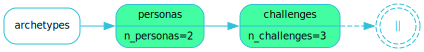

In [10]:
persona_challenge_pipeline = ak.chain(
    ak.step("archetypes", ARCHETYPE_LIST),
    ak.step("personas", generate_personas, n_personas=2),
    ak.step("challenges", generate_challenges, n_challenges=3),
)


persona_challenge_pipeline.draw()

And finally we run the pipeline:

In [11]:
# Run pipeline
result = ak.run(persona_challenge_pipeline)


# Convert results to dataframe and display
result_df = result.to_frame()
result_df.droplevel(0, axis=1).sort_values(["name", "persona"])

,name,description,persona,prompt
item,,,,
9,BEGINNER,"New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.","Recent college graduate in art, looking to assemble DIY furniture and hang artwork, seeks straightforward screwdriver advice.",What's the best screwdriver for assembling a wooden bookshelf?
10,BEGINNER,"New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.","Recent college graduate in art, looking to assemble DIY furniture and hang artwork, seeks straightforward screwdriver advice.",Can you recommend a screwdriver for mounting canvas frames?
11,BEGINNER,"New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.","Recent college graduate in art, looking to assemble DIY furniture and hang artwork, seeks straightforward screwdriver advice.",Need tips on using a screwdriver for DIY furniture projects.
0,BEGINNER,"New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.","Stay-at-home parent managing household repairs, unfamiliar with tools, needs basic screwdriver usage tips and product guidance.",What's the best screwdriver for simple home repairs?
1,BEGINNER,"New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.","Stay-at-home parent managing household repairs, unfamiliar with tools, needs basic screwdriver usage tips and product guidance.",How do I use a screwdriver to tighten cabinet hinges?
2,BEGINNER,"New to using screwdrivers and might feel overwhelmed by the variety of options available. They seek simple, clear guidance to make informed purchasing decisions and basic instructions on how to use screwdrivers.","Stay-at-home parent managing household repairs, unfamiliar with tools, needs basic screwdriver usage tips and product guidance.",Can you explain the different types of screwdrivers?
3,HOBBYIST,Enjoys tackling DIY home improvement projects. They are familiar with screwdrivers but might need guidance on more advanced uses of screwdrivers and product recommendations.,"Amateur carpenter, loves crafting furniture, looking for specialized screwdriver recommendations.",What screwdriver is best for making wooden chairs?
4,HOBBYIST,Enjoys tackling DIY home improvement projects. They are familiar with screwdrivers but might need guidance on more advanced uses of screwdrivers and product recommendations.,"Amateur carpenter, loves crafting furniture, looking for specialized screwdriver recommendations.",Can you recommend a durable screwdriver for furniture assembly?
5,HOBBYIST,Enjoys tackling DIY home improvement projects. They are familiar with screwdrivers but might need guidance on more advanced uses of screwdrivers and product recommendations.,"Amateur carpenter, loves crafting furniture, looking for specialized screwdriver recommendations.",Need advice on screwdrivers for intricate woodworking projects.


Perusing the persona prompts reveals that they reflect each persona's description.

## Concluding Remarks

In this tutorial, we demonstrated how to use ARTKIT to simulate user messages with LLM personas. The persona-based approach can be adapted to a wide range of use cases and contexts, including testing a system's performance when responding to typical user requests, out-of-scope user requests, and even adversarial users such as trolls. 

The [Examples](../../examples/index.rst) section of the documentation contains more realistic end-to-end examples. Tutorials that leverages single-turn personas include:

- [Single-Turn Personas: Brand Conformity](../../examples/proficiency/single_turn_persona_brand_conformity/notebook.ipynb)

Single-turn personas are a great starting point for identifying issues in conversational applications, but for conversational applications, multi-turn testing is necessary to identify problems that only emerge after repeated interactions. See our [Multi-Turn Personas](./multi_turn_personas.ipynb) for an introduction to testing with multi-turn personas.

Users are encouraged to build off this work. If you develop an interesting example, please consider [Contributing](../../contributor_guide/index.rst) to ARTKIT!